In [13]:
SYMBOL = "ARBUSDC"

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import numpy as np
import datetime as dt
from datetime import timedelta
import os
import glob

# Set up matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully!")
print("Ready to analyze Bitcoin data from CSV file!")


Libraries imported successfully!
Ready to analyze Bitcoin data from CSV file!


In [15]:
# Load Bitcoin data from CSV file
def find_bitcoin_csv():
    """Find Bitcoin CSV files in the current directory"""
    csv_files = glob.glob(f"{SYMBOL}_hourly_data_*.csv")
    return csv_files

def load_bitcoin_data(filename=None):
    """Load Bitcoin data from CSV file"""
    
    if filename is None:
        # Try to find Bitcoin CSV files automatically
        csv_files = find_bitcoin_csv()
        
        if not csv_files:
            print("No Bitcoin CSV files found in current directory.")
            print("Please ensure you have run the data fetching notebook first.")
            return None
        
        # Use the most recent file
        filename = max(csv_files, key=os.path.getctime)
        print(f"Found {len(csv_files)} Bitcoin CSV file(s)")
        print(f"Using most recent file: {filename}")
    
    try:
        # Load the CSV file
        df = pd.read_csv(filename)
        
        # Convert timestamp columns to datetime
        df['open_time'] = pd.to_datetime(df['open_time'])
        df['close_time'] = pd.to_datetime(df['close_time'])
        
        # Ensure data types are correct
        price_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
                         'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
        for col in price_columns:
            if col in df.columns:
                df[col] = df[col].astype(float)
        
        # Sort by open_time to ensure chronological order
        df = df.sort_values('open_time').reset_index(drop=True)
        
        print(f"✅ Successfully loaded {SYMBOL} data!")
        print(f"📊 Dataset: {len(df):,} hourly records")
        print(f"📅 Period: {df['open_time'].min().strftime('%Y-%m-%d %H:%M')} to {df['open_time'].max().strftime('%Y-%m-%d %H:%M')}")
        
        return df
        
    except FileNotFoundError:
        print(f"❌ Error: File '{filename}' not found.")
        print("Please check the filename and try again.")
        return None
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

# Load the data
df = load_bitcoin_data()

if df is not None:
    print("\n🎯 Data loaded successfully! Ready for analysis and visualization.")

Found 1 Bitcoin CSV file(s)
Using most recent file: ARBUSDC_hourly_data_20240630_20250630.csv
✅ Successfully loaded ARBUSDC data!
📊 Dataset: 8,761 hourly records
📅 Period: 2024-06-29 17:00 to 2025-06-29 17:00

🎯 Data loaded successfully! Ready for analysis and visualization.


In [16]:
# Uniswap Range Analysis Functions
def simulate_rebalancing(df, range_pct):
    """
    Simulate rebalancing for a given range percentage.
    
    Args:
        df: DataFrame with Bitcoin price data
        range_pct: Range percentage (e.g., 0.1 for 10%)
    
    Returns:
        dict: Results including number of rebalances, periods, etc.
    """
    if df is None or df.empty:
        return None
    
    prices = df['close'].values
    timestamps = df['open_time'].values
    
    rebalances = []
    current_center = prices[0]  # Start with first price as center
    half_range = range_pct / 2
    
    rebalance_count = 0
    periods = []  # Track how long each range lasted
    current_period_start = 0
    
    for i, price in enumerate(prices):
        # Calculate current range bounds
        lower_bound = current_center * (1 - half_range)
        upper_bound = current_center * (1 + half_range)
        
        # Check if price is outside range
        if price < lower_bound or price > upper_bound:
            # Record the period length
            period_length = i - current_period_start
            if period_length > 0:
                periods.append(period_length)
            
            # Rebalance: set new center to current price
            current_center = price
            rebalance_count += 1
            current_period_start = i
            
            rebalances.append({
                'timestamp': timestamps[i],
                'price': price,
                'rebalance_number': rebalance_count
            })
    
    # Add final period
    final_period = len(prices) - current_period_start
    if final_period > 0:
        periods.append(final_period)
    
    return {
        'range_pct': range_pct,
        'rebalance_count': rebalance_count,
        'rebalances': rebalances,
        'periods': periods,
        'avg_period_hours': np.mean(periods) if periods else 0,
        'min_period_hours': min(periods) if periods else 0,
        'max_period_hours': max(periods) if periods else 0,
        'total_hours': len(prices)
    }

def analyze_range_efficiency(df, range_percentages):
    """
    Analyze rebalancing efficiency across different range percentages.
    
    Args:
        df: DataFrame with Bitcoin price data
        range_percentages: List of range percentages to test
    
    Returns:
        DataFrame: Results for each range percentage
    """
    results = []
    
    print(f"🔍 Analyzing {len(range_percentages)} different range sizes...")
    print("Progress: ", end="")
    
    for i, range_pct in enumerate(range_percentages):
        if i % 5 == 0:  # Progress indicator
            print(f"{i//5}", end="")
        
        result = simulate_rebalancing(df, range_pct)
        if result:
            results.append({
                'range_pct': range_pct * 100,  # Convert to percentage
                'range_width': f"±{range_pct*50:.1f}%",  # Half range each side
                'rebalance_count': result['rebalance_count'],
                'avg_period_hours': result['avg_period_hours'],
                'avg_period_days': result['avg_period_hours'] / 24,
                'rebalances_per_month': result['rebalance_count'] / (len(df) / (24 * 30)),
                'efficiency_score': range_pct / (result['rebalance_count'] + 1)  # Lower is better
            })
    
    print(" ✅ Complete!")
    return pd.DataFrame(results)

# Test with a range of percentages from 1% to 50%
range_percentages = [i/100 for i in range(1, 51)]  # 1% to 50% in 1% increments

if df is not None:
    print("🚀 Starting range efficiency analysis...")
    results_df = analyze_range_efficiency(df, range_percentages)
    print(f"\\n📈 Analysis complete! Tested {len(results_df)} range configurations.")

    # Save results to CSV for further analysis
    results_df.to_csv(f'{SYMBOL}_uniswap_range_analysis_results.csv', index=False)
    print(f"\\n💾 Results saved to 'uniswap_range_analysis_results.csv'")


🚀 Starting range efficiency analysis...
🔍 Analyzing 50 different range sizes...
Progress: 0123456789 ✅ Complete!
\n📈 Analysis complete! Tested 50 range configurations.
\n💾 Results saved to 'uniswap_range_analysis_results.csv'


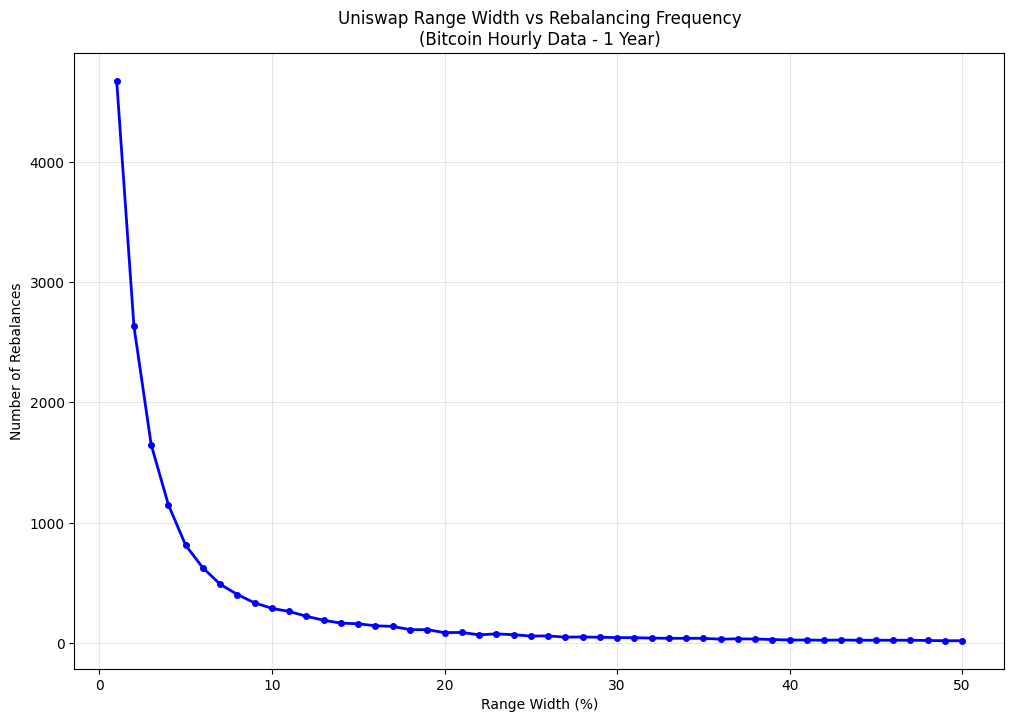

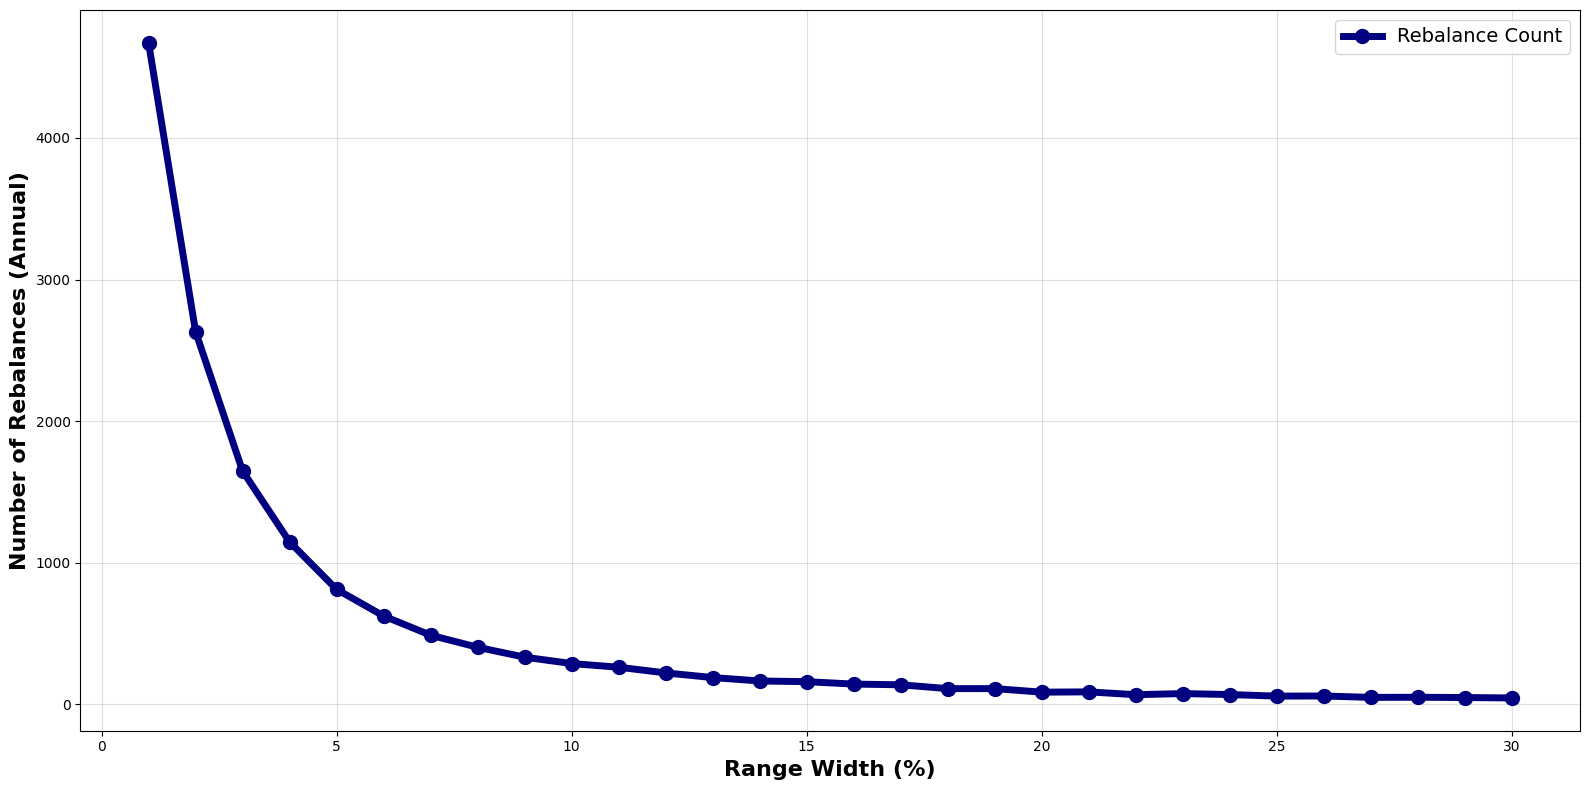

In [17]:
# Create fixed visualizations
if 'results_df' in locals() and not results_df.empty:
    
    # Create a simple plot for now
    plt.figure(figsize=(12, 8))
    plt.plot(results_df['range_pct'], results_df['rebalance_count'], 'b-o', linewidth=2, markersize=4)
    plt.xlabel('Range Width (%)')
    plt.ylabel('Number of Rebalances')
    plt.title('Uniswap Range Width vs Rebalancing Frequency\n(Bitcoin Hourly Data - 1 Year)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
# Create comprehensive visualization for optimal range analysis
if 'results_df' in locals() and not results_df.empty:
    # Create the OPTIMAL RANGE FINDER plot
    plt.figure(figsize=(16, 8))
    
    # Focus on practical ranges (1-30%)
    practical_ranges = results_df[(results_df['range_pct'] >= 1) & (results_df['range_pct'] <= 30)]
    
    plt.plot(practical_ranges['range_pct'], practical_ranges['rebalance_count'], 
             'navy', linewidth=5, marker='o', markersize=10, label='Rebalance Count')
    
    # Find and highlight the sweet spot
    practical_min = practical_ranges.loc[practical_ranges['rebalance_count'].idxmin()]
    
    plt.plot(practical_min['range_pct'], practical_min['rebalance_count'])
    
    plt.xlabel('Range Width (%)', fontsize=16, fontweight='bold')
    plt.ylabel('Number of Rebalances (Annual)', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.4)
    plt.legend(fontsize=14)
    
    plt.tight_layout()
    plt.show()
    

In [18]:
# Final recommendations and analysis
if 'results_df' in locals() and not results_df.empty:
    print("🎯 BEST UNISWAP LIQUIDITY RANGES")
    print("=" * 60)
    
    # Create a focused analysis on the most promising ranges
    top_candidates = results_df[results_df['range_pct'] <= 25].copy()
    
    # Calculate additional metrics for decision making
    top_candidates['rebalance_cost_factor'] = top_candidates['rebalance_count'] * 0.001  # Assume 0.1% cost per rebalance
    top_candidates['capital_efficiency'] = 1 / top_candidates['range_pct']  # Higher is better for narrow ranges
    top_candidates['combined_score'] = (top_candidates['efficiency_score'] * 0.6 + 
                                       top_candidates['rebalance_cost_factor'] * 0.4)  # Weighted combination

    best_ranges = top_candidates.nsmallest(1, 'combined_score')
    for idx, row in best_ranges.iterrows():
        print(f"🔹 {row['range_width']} - {row['rebalance_count']} rebalances")
        print(f"   └ Average period: {row['avg_period_days']:.1f} days")
        print(f"   └ Monthly rebalances: {row['rebalances_per_month']:.1f}")
        print(f"   └ Combined score: {row['combined_score']:.4f}")


🎯 BEST UNISWAP LIQUIDITY RANGES
🔹 ±12.5% - 58 rebalances
   └ Average period: 6.2 days
   └ Monthly rebalances: 4.8
   └ Combined score: 0.0257
